In [1]:
# Домашнее задание
# Предсказание временных рядов
# 1. Скачать датасет Х.
# 2. Натренировать модель ARIMA, перебором подобрать наилучший набор параметров.
# 3. Натренировать одну из ML моделей на предсказание следующего значения временного ряда.
# Критерии оценки: 1. Корректность реализации в п.2.
# 2. Корректно реализован выбор модели в п. 3

In [2]:
import pandas as pd

RAW_CRIME_DATA = pd.read_csv('Datasets/rows.csv')
# Дата сет есть в репозитории, но он весит ~560 МБ разумеется я не включу его в коммит
# Посмотреть на исходный датасет можно по ссылке https://www.kaggle.com/tsaustin/austin-crime-dataset-16-years-of-data

/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
from dateutil.parser import parse
import collections
from datetime import datetime

# Очистим датасет
# Из всечго дата сета нам нужна только дата. И посчитать сколько строчек есть с этой датой.
dates = RAW_CRIME_DATA.get('Occurred Date').tolist()

timestamps = [int(parse(date).timestamp()) for date in dates]
timestamp_frequencies = collections.Counter(timestamps)

ordered_timestamps = [ts for ts in timestamp_frequencies.keys()]
ordered_timestamps.sort()
ordered_dates = []
ordered_frequencies = []

for ts in ordered_timestamps:
    ordered_dates += [datetime.utcfromtimestamp(ts).date()]
    ordered_frequencies += [timestamp_frequencies[ts]]


In [2]:
# Запишем результат в файл, чтобы не производить очистку каждый раз
clarified_df = pd.DataFrame(data={'date': ordered_dates, 'timestamp': ordered_timestamps, 'incidents': ordered_frequencies})
clarified_df.to_csv('Datasets/clarified_data.csv')

NameError: name 'ordered_dates' is not defined

In [4]:
# Напишем фунцкию для отображения данных на интервале
import matplotlib.pyplot as plt
import pandas as pd

def print_interval(df, start=0, end=-1):
    restrict_df = df[start:end]
    print_statistic_plot(restrict_df)
    return

def print_statistic_plot(df):
    dates = df.get('date').tolist()
    incidents = df.get('incidents').tolist()

    plt.figure()
    fig, axs = plt.subplots(1, 1, figsize=(16, 8))

    axs.plot(dates, incidents, color='blue')
    axs.set_xlabel('Dates')
    axs.set_ylabel('Incidents')
    axs.set_title('{0} - {1}'.format(dates[0], dates[-1]))
    axs.grid(True)

    fig.tight_layout()

    plt.grid(True)

    plt.show()

    return

clarified_df = pd.read_csv('Datasets/clarified_data.csv')

<Figure size 432x288 with 0 Axes>

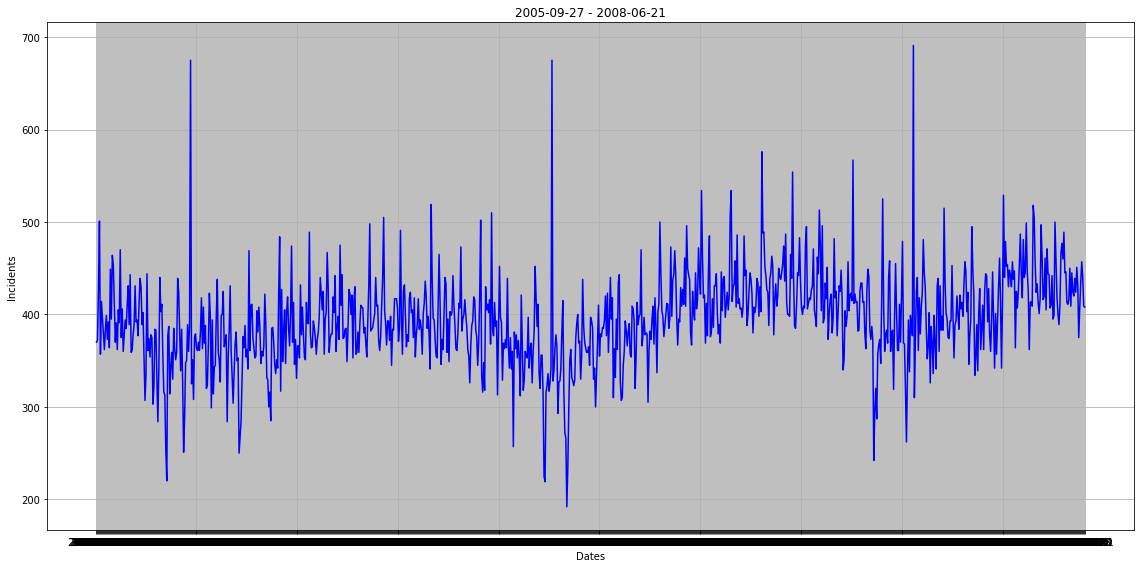

In [5]:
# Возьмём случайный интервал. Посмотрим как выглядят данные
print_interval(clarified_df, 1001, 2000)
# То, что надо. Именно таких данные необходимы для изучения временных рядов.

<Figure size 432x288 with 0 Axes>

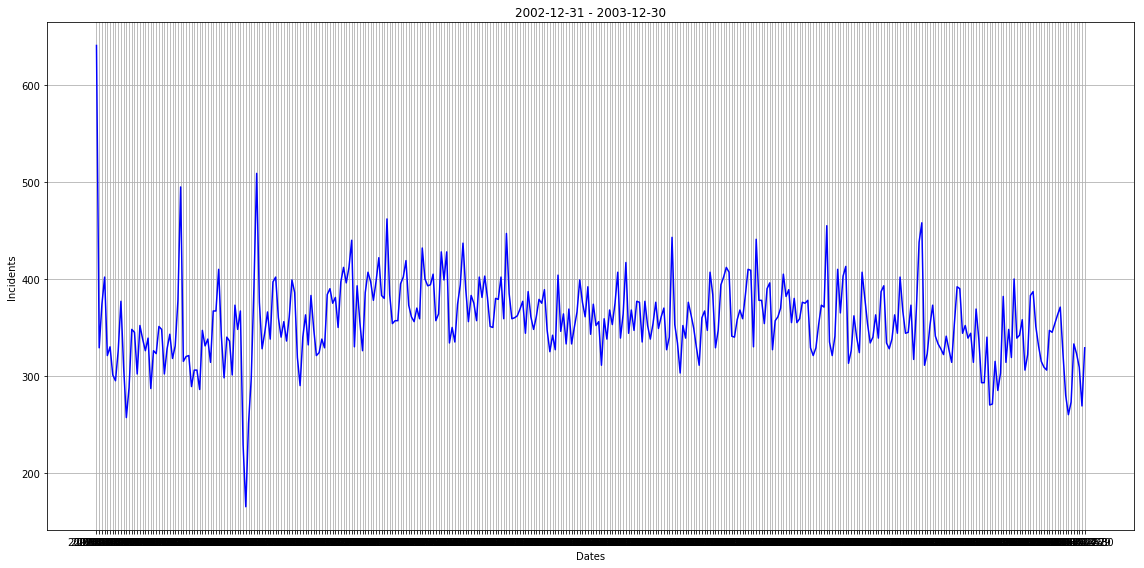

In [18]:
# Выведем данные за первый год
print_interval(clarified_df, 0, 365)

<Figure size 432x288 with 0 Axes>

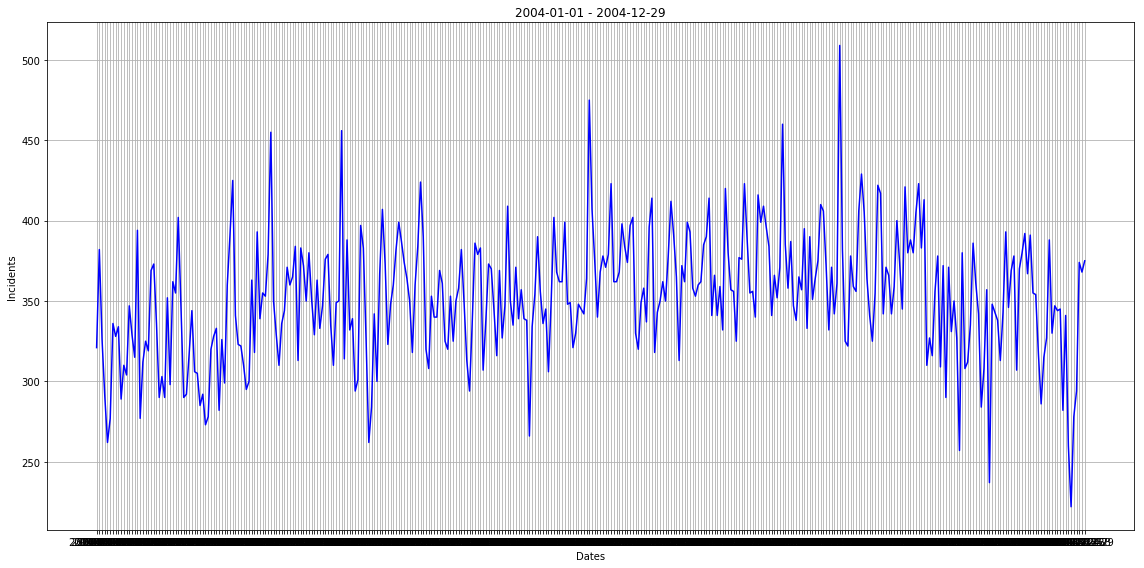

In [18]:
# Выведем данные за второй год
print_interval(clarified_df, 366, 730)

<Figure size 432x288 with 0 Axes>

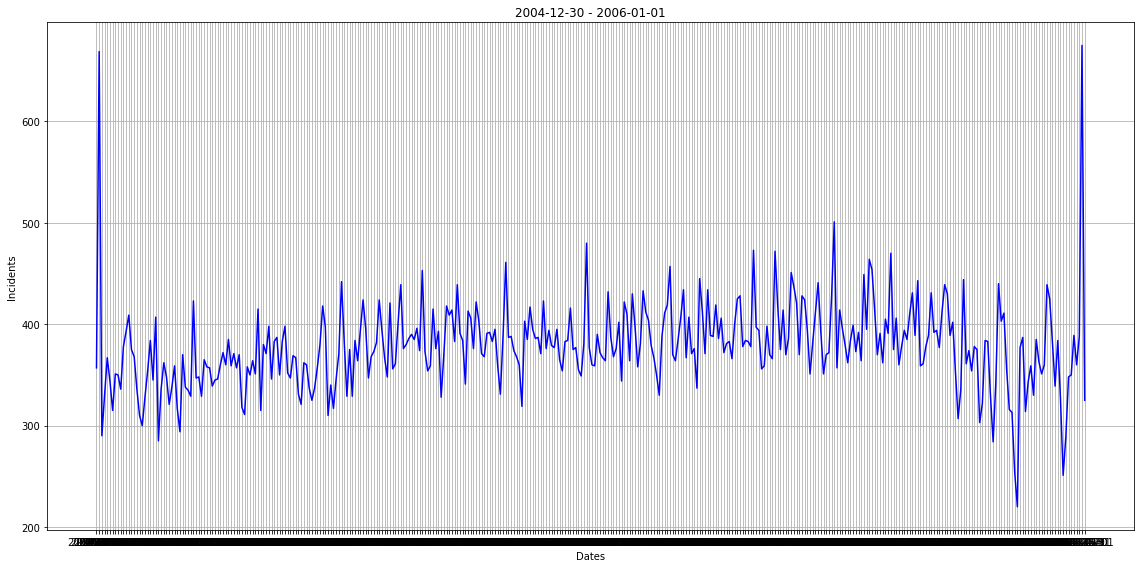

In [18]:
print_interval(clarified_df, 730, 1098)

In [5]:
# Посмотрим как методы приближения работают.

from matplotlib.pyplot import figure

def print_with_approximation(values_series, approximation):
    figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(values_series, label=u"Исходные данные")
    plt.plot(approximation, label=u"Приближение")
    plt.legend()
    plt.ylabel('Incidents')
    plt.show()

    return



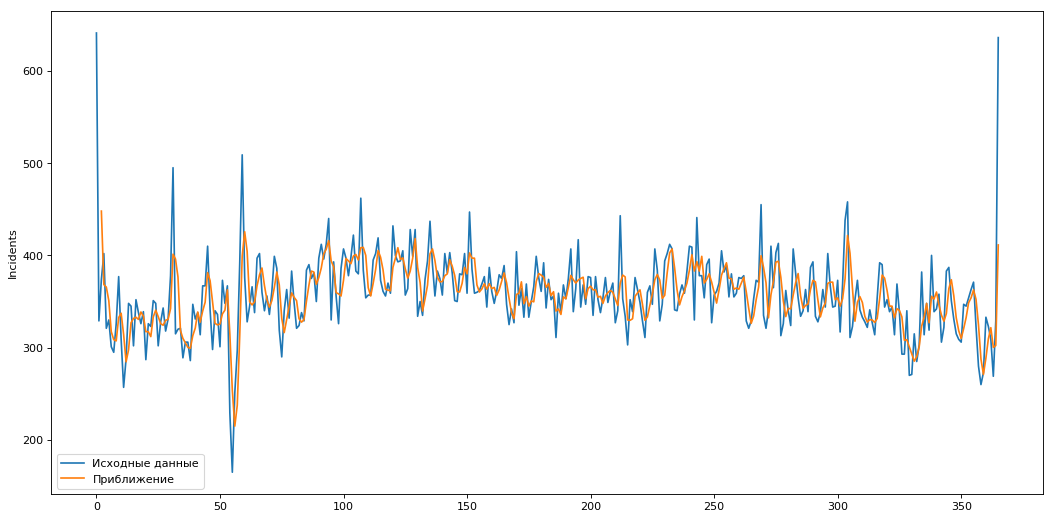

In [6]:
# Проверим скользящее среднее

data_frame = clarified_df[0:366]
n = 3

incedents_series = pd.Series(data_frame.get('incidents').tolist())
rolling_mean = incedents_series.rolling(window=n).mean()

print_with_approximation(incedents_series, rolling_mean)

# Достаточно неплохо

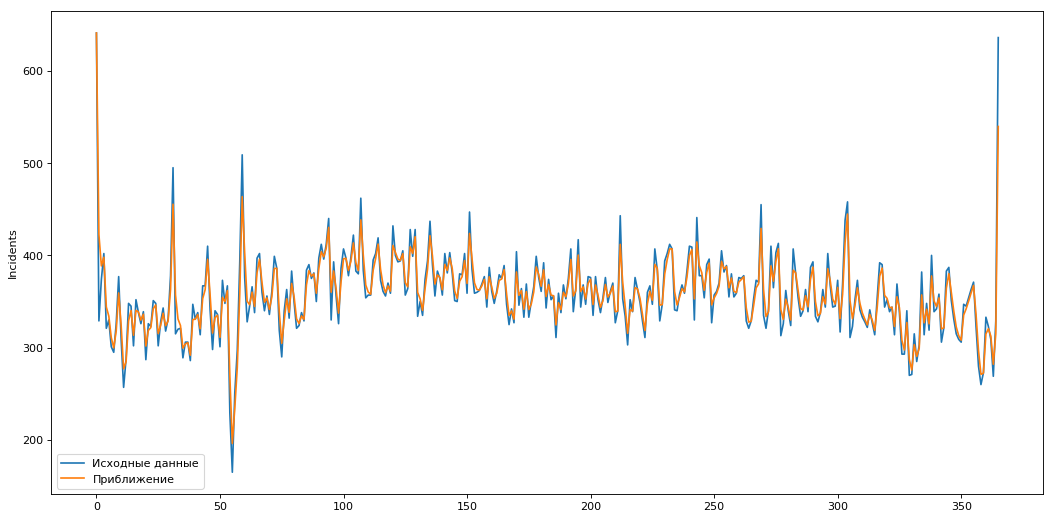

In [7]:
# Проверим экспонентациальное сглаживание
data_frame = clarified_df[0:366]

def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

incidents_series = pd.Series(data_frame.get('incidents').tolist())
smoothing_series = exponential_smoothing(incedents_series, 0.7)

print_with_approximation(incidents_series, smoothing_series)

# Результат гораздо лучше

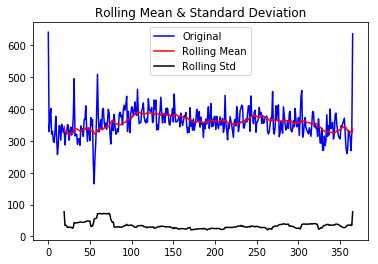

Results of Dickey-Fuller Test:
Test Statistic                  -2.616162
p-value                          0.089703
#Lags Used                      16.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


In [8]:
# Проверим стационарность

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window_size=1):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationarity(incidents_series, 20)
# Ряд явно не стационарный

In [9]:
from dateutil.parser import parse
from datetime import datetime
import time

# На самом деле строить ряд по каждому отдельному дню - бессмысленно. Данные слишком случайны. В них вряд ли найдётся найти какую-то закономерность. 
# Суммируем данные по месяцам. Таким образом получим понятный дата сет с окном 12. В котором сможем теоретически найти и стационарность и сезонность.

years = []
months = []
incidents = []
incidents_buffer = 0

# Первый элемент принадлежит 2002 году, второй - 2003, избавляемся, чтобы не было аномалии, поэтому начинаем с индекса 2.
first_element_index = 2

def parse_year_month(string_date):
    row_date = datetime.utcfromtimestamp(int(parse(string_date).timestamp())).date()
    year = row_date.year
    month = row_date.month
    return year, month

first_element = clarified_df[first_element_index:3]
initial_year, initial_month = parse_year_month(first_element.get('date').tolist()[0])
years += [initial_year]
months += [initial_month]

max_index = len(clarified_df) - 1

t1 = time.time()
for i, row in clarified_df[first_element_index:].iterrows():
    year, month = parse_year_month(row[1])

    if (years[-1] != year) or (months[-1] != month):
        years += [year]
        months += [month]
        incidents_buffer += row[3]
        incidents += [incidents_buffer]
        incidents_buffer = 0
    elif i == max_index:
        incidents_buffer += row[3]
        incidents += [incidents_buffer]
        incidents_buffer = 0
    else:
        incidents_buffer += row[3]

t2 = time.time()

print(t2 - t1)
print(years)
print(months)
print(incidents)


1.4165654182434082
[2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20

In [10]:
# gen - generalized
gen_df = pd.DataFrame({'year': years, 'month': months, 'incidents': incidents})
gen_df.to_csv('Datasets/gen_df.csv')

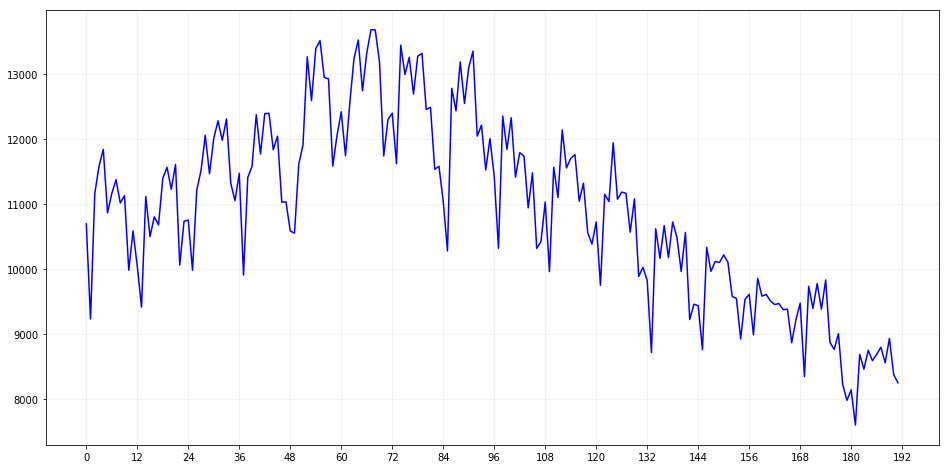

In [11]:
import numpy as np
import matplotlib.pyplot as plt

gen_df = pd.read_csv('Datasets/gen_df.csv')

# Обрежем последние 3 месяца наблюдений, это 1,2,3 месяцы 2016 года.

gen_df = gen_df[0:-3]

major_ticks = np.arange(0, 193, 12)

incidents_series = pd.Series(gen_df.get('incidents').tolist())

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(incidents_series, color='blue')
ax.set_xticks(major_ticks)
ax.grid(which='major', alpha=0.2)

plt.show()
# Шаг сетки - 12, это 12 месяцев. При грубом рассмотрении, паттерн, цикличность, сезонность есть.

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window_size=1):

    major_ticks = np.arange(0, len(timeseries) + 1, window_size)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1, 1, 1)

    orig = ax.plot(timeseries, color='blue',label='Original')
    mean = ax.plot(rolmean, color='red', label='Rolling Mean')
    std = ax.plot(rolstd, color='black', label = 'Rolling Std')
    ax.set_xticks(major_ticks)
    ax.grid(which='major', alpha=0.2)

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

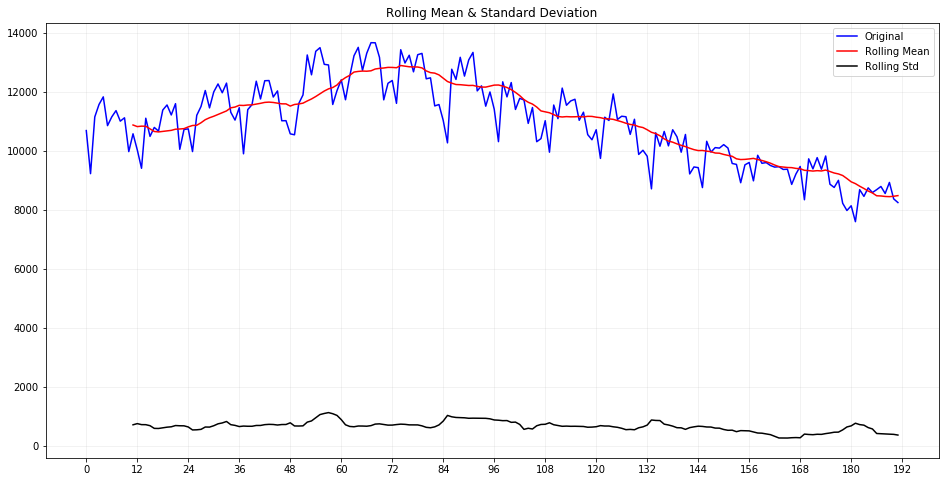

Results of Dickey-Fuller Test:
Test Statistic                  -0.318336
p-value                          0.922867
#Lags Used                      14.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64


In [13]:
# Окно - 12 месяцев
test_stationarity(incidents_series, 12)
# Судя по тесту - ряд не стационарный. p-value имеет большое значение, значит ряд скорее всего не стационарный.
# Для этого - вычтем скользящее среднее из каждого интервала в 12 месяцев.

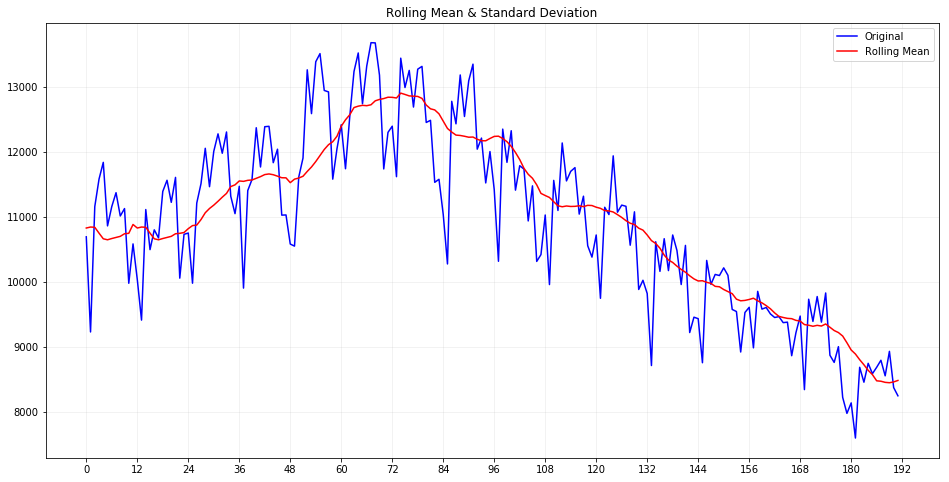

In [14]:
# Попробуем вычесть скользящее среднее.

window_size = 12

rolling_mean = incidents_series.rolling(window=window_size).mean()

# Из-за ширины окна - первые 11 элементов отсутстуют. Число на глаз первый и второй год наблюдения идентичны. Скопируем вторые 11 элементов, начичная с первого песяца 12
rolling_mean[:11] = rolling_mean[12:23]

major_ticks = np.arange(0, len(incidents_series) + 1, window_size)
#Determing rolling statistics
rolmean = incidents_series.rolling(window=window_size).mean()
rolstd = incidents_series.rolling(window=window_size).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 1, 1)

orig = ax.plot(incidents_series, color='blue',label='Original')
mean = ax.plot(rolling_mean, color='red', label='Rolling Mean')
ax.set_xticks(major_ticks)
ax.grid(which='major', alpha=0.2)

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [15]:
# Избавимся от нелинейного тренда. Вычтем из исходных данных скользящее среднее и прибавим 3000, чтобы процесс не принимал отрицательные значения.
normalized_incidents = incidents_series - rolling_mean + 3000

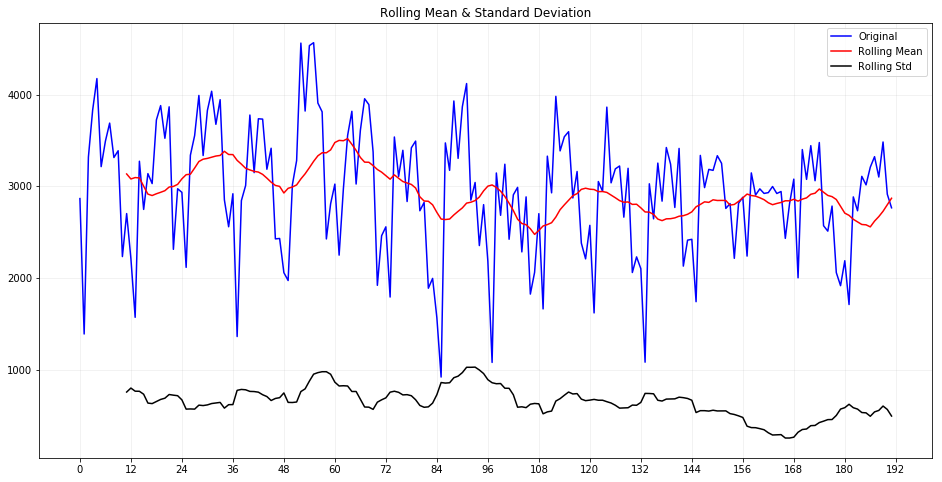

Results of Dickey-Fuller Test:
Test Statistic                  -2.632933
p-value                          0.086380
#Lags Used                      12.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


In [16]:
# Проверим на стационарность
test_stationarity(normalized_incidents, 12)
# p-value снизилось. Но ряд по-прежнему нельзя назвать стационарным.

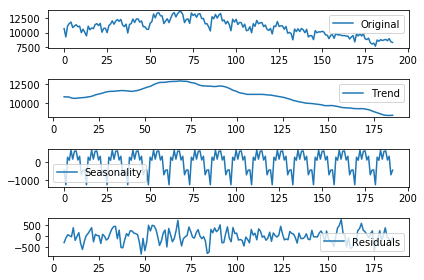

In [17]:
# Попробуем воспользоваться возможностями библиотеки
from statsmodels.tsa.seasonal import seasonal_decompose

incidents_list = gen_df.get('incidents').tolist()
incidents_df = gen_df.get('incidents')
decomposition = seasonal_decompose(incidents_df, freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(incidents_list, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

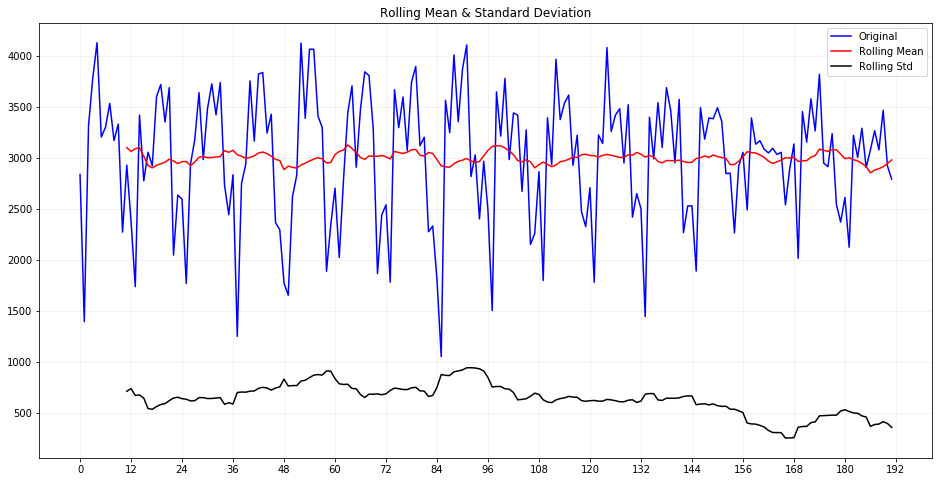

Results of Dickey-Fuller Test:
Test Statistic                  -5.605420
p-value                          0.000001
#Lags Used                      12.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


In [18]:
trick_trend = trend
trick_trend[0:6] = trick_trend[6:12]
trick_trend[185:] = trick_trend[178:185]
normalized_incidents = incidents_df - trend + 3000

test_stationarity(normalized_incidents, 12)
# Test Statistic < Critical Value. p-value снизилось до очень маленького значения. Ряд скорее всего является стационаным. 
# Это видно и на графиках - разброс скользящего среднего значения сильно меньше разброса самого ряда.

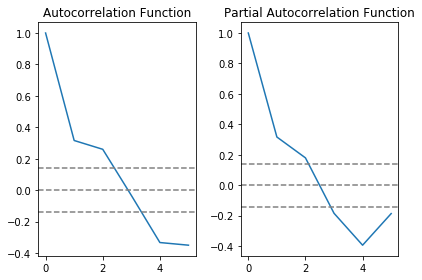

In [19]:
# Приступим к обучению модели ARIMA
# p - Number of AR (Auto-Regressive) terms
# На сколько шагов смотреть назад
# q - Number of MA (Moving Average) terms На сколько шагов смотреть назад ошибку предсказания (отличие от скользящего среднего)
# d - Number of Differences (d) Длина сезона

from statsmodels.tsa.stattools import acf, pacf
nlags = 5
lag_acf = acf(normalized_incidents, nlags=nlags)
lag_pacf = pacf(normalized_incidents, nlags=nlags, method='ols')

#Plot ACF: 
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(normalized_incidents)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(normalized_incidents)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(normalized_incidents)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(normalized_incidents)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Методом перебора выяснили что:
q = 2
p = 2

In [20]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: 1864366245.6023')

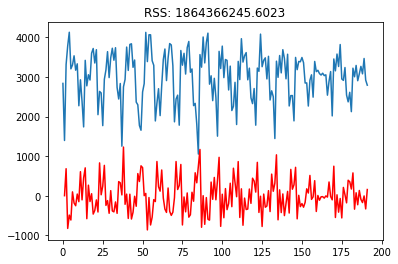

In [21]:
model = ARIMA(normalized_incidents, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(normalized_incidents)
result = results_ARIMA.fittedvalues
plt.plot(result, color='red')
plt.title('RSS: %.4f'% (((result - normalized_incidents[:-1])**2).sum()))
# Ошибка огромная. Нужно подстроить атрибуты модели. Да элементрно по графику видно, что модель оторвана от реальности.

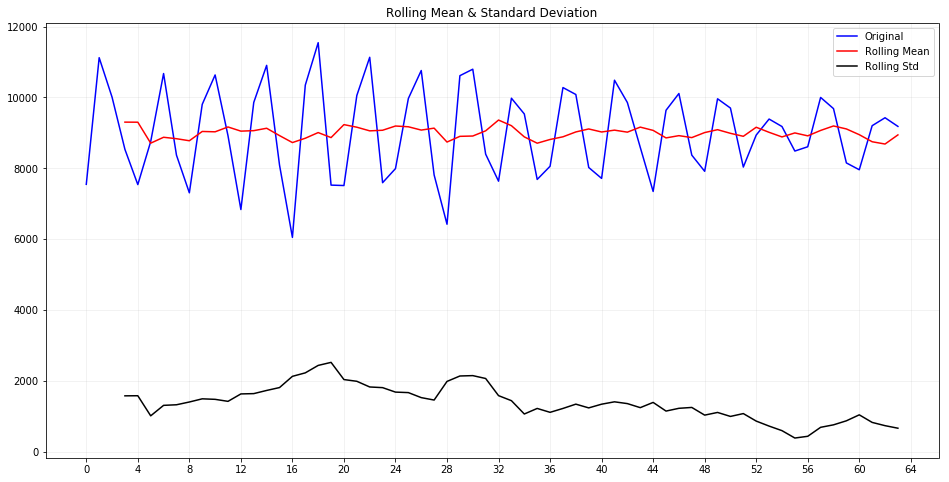

Results of Dickey-Fuller Test:
Test Statistic                 -4.098942
p-value                         0.000972
#Lags Used                      9.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [22]:
# Дальше было несколько безуспешных попыток построить модель по дата сету со статистикой по месяцам.
# В конечном итоге я решил сделать статистику по сезонам. Тоесть по 3 месяца. И этот дата сет был статичным, был пригоден для обучения.
# Ниже приведу алгоритм для финального решения.

s = 3
season_statistic = normalized_incidents.copy(deep=True)
season_statistic = season_statistic.groupby(season_statistic.index // s).sum()

test_stationarity(season_statistic, 4)
# Уже при первом приблизении видно что дата сет стационарный.
# Скользящая средняя практически прямая.
# Дести Дикей-Фулера пройден, ряд стационарен.

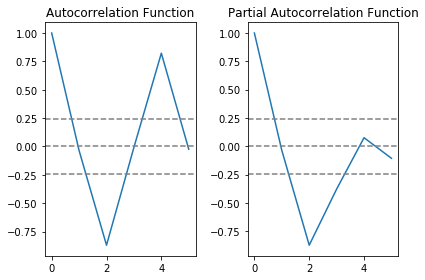

In [23]:
# Приступим к обучению модели ARIMA
# p - Number of AR (Auto-Regressive) terms
# На сколько шагов смотреть назад
# q - Number of MA (Moving Average) terms На сколько шагов смотреть назад ошибку предсказания (отличие от скользящего среднего)
# d - Number of Differences (d) Длина сезона

from statsmodels.tsa.stattools import acf, pacf
nlags = 5
lag_acf = acf(season_statistic, nlags=nlags)
lag_pacf = pacf(season_statistic, nlags=nlags, method='ols')

#Plot ACF: 
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(season_statistic)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(season_statistic)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(season_statistic)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(season_statistic)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Начальыне значения для модели:
q = 1
p = 1

Text(0.5, 1.0, 'RSS: 5216.1869')

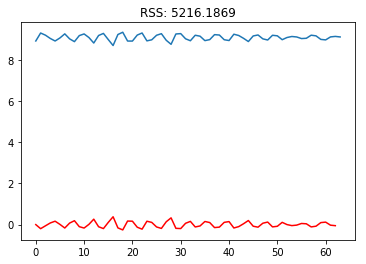

In [24]:
# Уменьшим масштаб модели, чтобы снизить ошибку.
log_season_statistic = np.log(np.array(season_statistic.tolist()))

model = ARIMA(log_season_statistic, order=(1, 1, 1))

results_ARIMA = model.fit(disp=-1)
plt.plot(log_season_statistic)
result = results_ARIMA.fittedvalues
plt.plot(result, color='red')
plt.title('RSS: %.4f'% (((result - log_season_statistic[:-1])**2).sum()))
# Модель не сходится. Судя по всему она всегда показывает данные около 0. СЛедовательно нужно опустить ряд до нулевой отметки
# и проверить после этого.

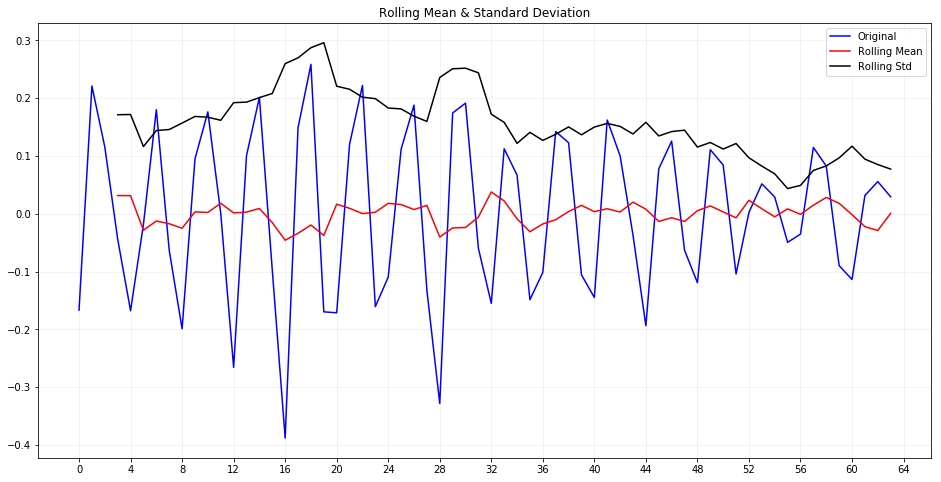

Results of Dickey-Fuller Test:
Test Statistic                 -5.153580
p-value                         0.000011
#Lags Used                      5.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


In [25]:
# Вычтем из ряда среднее значение и проверим на стационарность.
normalized_season_statistic = log_season_statistic - np.ma.average(log_season_statistic)
normalized_season_series = pd.Series(normalized_season_statistic)

test_stationarity(normalized_season_series, 4)
# Ряд по прежнему стационарный.

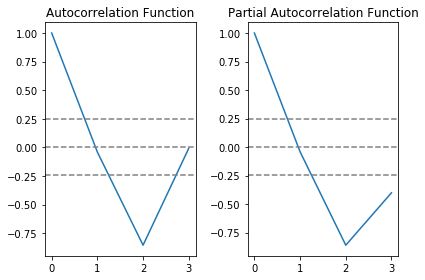

In [26]:
# Приступим к обучению модели ARIMA
# p - Number of AR (Auto-Regressive) terms
# На сколько шагов смотреть назад
# q - Number of MA (Moving Average) terms На сколько шагов смотреть назад ошибку предсказания (отличие от скользящего среднего)
# d - Number of Differences (d) Длина сезона

from statsmodels.tsa.stattools import acf, pacf
nlags = 3
lag_acf = acf(normalized_season_series, nlags=nlags)
lag_pacf = pacf(normalized_season_series, nlags=nlags, method='ols')

#Plot ACF: 
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(normalized_season_series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(normalized_season_series)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(normalized_season_series)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(normalized_season_series)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Оптимальные значения по-прежнему:
q = 1
p = 1

Text(0.5, 1.0, 'RSS: 5.2767')

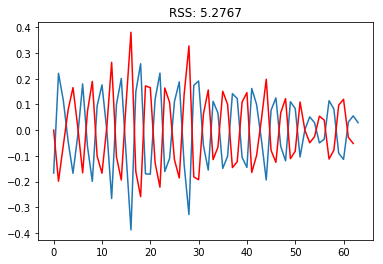

In [27]:
model = ARIMA(log_season_statistic, order=(1, 1, 1))

results_ARIMA = model.fit(disp=-1)
plt.plot(normalized_season_series)
result = results_ARIMA.fittedvalues
plt.plot(result, color='red')
plt.title('RSS: %.4f'% (((result - normalized_season_series[:-1])**2).sum()))
# Модель получилась как будто зеркальная противоположность. Попробуем домлножить на -1

Text(0.5, 1.0, 'RSS: 0.0344')

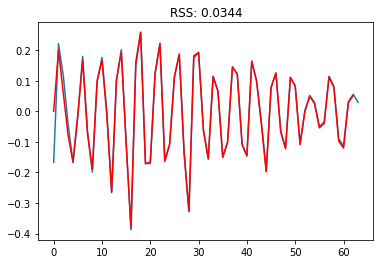

In [28]:
model = ARIMA((-1) * log_season_statistic, order=(1, 1, 1))

results_ARIMA = model.fit(disp=-1)
plt.plot(normalized_season_series)
result = results_ARIMA.fittedvalues
plt.plot(result, color='red')
plt.title('RSS: %.4f'% (((result - normalized_season_series[:-1])**2).sum()))
# RSS residual sum of squares - показатель очень маленький
# Сказка.

Text(0.5, 1.0, 'RMSE: 1072.2035')

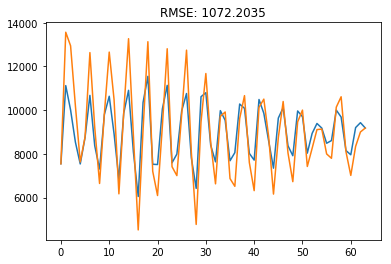

In [29]:
# Проведём обратные преобразования полученной модели.

pd_log_season_statistic = pd.DataFrame({'incidents': log_season_statistic})

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(log_season_statistic, index=pd_log_season_statistic.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(season_statistic)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-season_statistic)**2)/len(season_statistic)))
# Может показаться что 1072.2035 это много. Но если учесть масштаб предсказания - это копейки. 
# Сравните с предыдущими попытками и всё санет ясно.
# RMSE Root Mean Square Error

In [30]:
# Попробуем найти самый лучший набор параметров с помощью GridSearch

p = range(0, 5)
d = (1,)
q = range(0, 4)

from itertools import product

parameters = product(p, d, q)
parameters_list = list(parameters)

for p, d, q in parameters_list:
    try:
        model = ARIMA((-1) * log_season_statistic, order=(p, d, q))
        results_ARIMA = model.fit(disp=-1)
        rss = sum((results_ARIMA.fittedvalues - normalized_season_series[:-1])**2)
        print('for p={}, d={}, q={} RSS is {}'.format(p, d, q, rss))
    except ValueError:
        print('Invalid attrs ({0}, {1}, {2}'.format(p, d, q))
# По - прежнему самый оптимальный набор параметров
p = 1
d = 1
q = 1

# Однако если модель супер точно подходит, значит она скорее всего переобученна
# Посмотрим другие, так же дающие низкий показатель RSS
p = 2
d = 1
q = 2

p = 3
d = 1
q = 1

p = 4
d = 1
q = 3

/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`

for p=0, d=1, q=0 RSS is 1.3482685811494648
for p=0, d=1, q=1 RSS is 0.035195774222705416
Invalid attrs (0, 1, 2
Invalid attrs (0, 1, 3
for p=1, d=1, q=0 RSS is 1.1220518286434176


for p=1, d=1, q=1 RSS is 0.03440237517564263
Invalid attrs (1, 1, 2
Invalid attrs (1, 1, 3
for p=2, d=1, q=0 RSS is 1.001850251737006


for p=2, d=1, q=1 RSS is 1.0796827491067493


/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


for p=2, d=1, q=2 RSS is 1.1068623007810847
Invalid attrs (2, 1, 3
for p=3, d=1, q=0 RSS is 1.1325913586919005


for p=3, d=1, q=1 RSS is 1.118652108343188


for p=3, d=1, q=2 RSS is 1.125397075856999


/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


for p=3, d=1, q=3 RSS is 1.1406900448262152


for p=4, d=1, q=0 RSS is 1.132609162602425


/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


for p=4, d=1, q=1 RSS is 1.127225956386011


/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


for p=4, d=1, q=2 RSS is 1.1273410317801085


for p=4, d=1, q=3 RSS is 1.1113856035298437


/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'RSS: 1.1114')

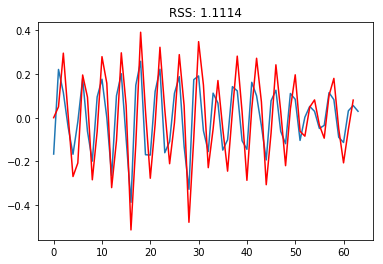

In [251]:
# Перебрав было решено использовать набор 4, 1, 3.
# Потому, что в году 4 сезона, логично что регрессию строить необходимо по 4 предыдущим шагам

model = ARIMA((-1) * log_season_statistic, order=(4, 1, 3))

results_ARIMA = model.fit(disp=-1)
plt.plot(normalized_season_series)
result = results_ARIMA.fittedvalues
plt.plot(result, color='red')
plt.title('RSS: %.4f'% (((result - normalized_season_series[:-1])**2).sum()))

Text(0.5, 1.0, 'RMSE: 1610.3242')

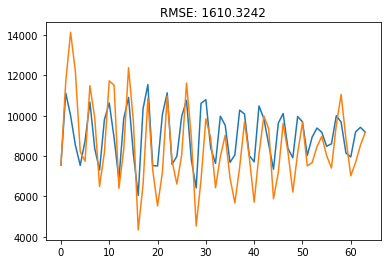

In [253]:
# Проведём преобразования и построим финальный график модели
pd_log_season_statistic = pd.DataFrame({'incidents': log_season_statistic})

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(log_season_statistic, index=pd_log_season_statistic.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(season_statistic)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-season_statistic)**2)/len(season_statistic)))
# Задание выполнено.

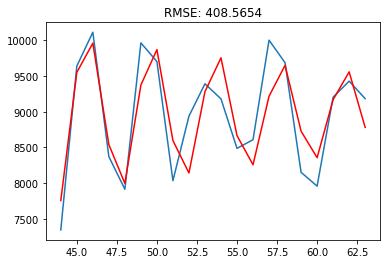

In [283]:
# Проведём кросс валидацию
def cross_validation(data_list, original_data_list, train_coefficient, p, d, q):
    train_index = int(len(data_list) * train_coefficient)
    forecasting_length = len(data_list) - train_index

    # Сформируем тренировочный и проверочный дата сеты.
    train_set = data_list[:train_index]
    test_set = original_data_list[train_index:]

    # Обучим модель
    model = ARIMA(train_set, order=(p, d, q))

    results_ARIMA =  model.fit(disp=-1)
    # Совершим приедсказание
    result = results_ARIMA.forecast(steps=forecasting_length)[0]
    
    # Приведём предсказание к изначальному значению, до нормализации.
    result = np.exp(result)
    result = pd.Series(result, index=test_set.index)

    plt.plot(original_data_list[train_index:])
    plt.plot(result, color='red')

    # В качяестве метрики используем RMSE 
    title = 'RMSE: %.4f'% np.sqrt(sum((result - test_set)**2)/forecasting)
    plt.title(title)

cross_validation(log_season_statistic, season_statistic, 0.7, 3, 1, 2)
# Видно что модель достаточно хорошо подходит под тестовые данные. RMSE, учитывая масштаб прдсказания, имеет небольшие значения.

/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


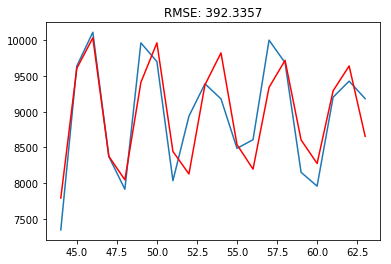

In [291]:
# Здесь я несколько раз менял параметры. В итоге оставлил те, что давали лучшиий показатель метрики качества.
cross_validation(log_season_statistic, season_statistic, 0.7, 5, 1, 2)
# Задание выполнено.